In [1]:
import sys
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

### Parameters

All parameters are from https://arxiv.org/abs/1701.07875 and https://arxiv.org/abs/1704.00028

In [2]:
dataroot = "../../share_dataset/six_objects_1000stimuli/"
num_epochs_alex = 5
num_epochs = 80
workers = 1
batch_size = 128
image_size = 64
num_channel = 3 #<---change 
z_dim = 100
gen_dim = 64
dis_dim = 64
ngpu = 1
lr = 1e-4 #<-----changed
dis_iter = 2
lambda_gp = 10
num_classes = 4
embed_size = 100 #<---follow the paper
feature_size = 200

### Load dataset

In [3]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),  
                            #    transforms.Normalize([0.5 for _ in range(num_channel)], [0.5 for _ in range(num_channel)]), 
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                           ]))
# from torch.utils.data import Subset

# idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] != dataset.class_to_idx['idle']]
# print(idx)

# subset = Subset(dataset, idx)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

real_batch = next(iter(dataloader))

print("Min (should be -1): ", real_batch[0].min())
print("Max (should be 1): ", real_batch[0].max())
print("X shape: (batch, C, H, W)  ", real_batch[0].shape)
print("Label shape: (batch)  ", real_batch[1].shape)
print("Label unique values: (batch)  ", real_batch[1].unique())

# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Device:  cuda:1
Min (should be -1):  tensor(-2.1179)
Max (should be 1):  tensor(2.6400)
X shape: (batch, C, H, W)   torch.Size([128, 3, 64, 64])
Label shape: (batch)   torch.Size([128])
Label unique values: (batch)   tensor([0, 1, 2, 3])


### Weight Initialization

In [4]:
# custom weights initialization called on netG and netD
def weights_init(model):
    for m in model.modules(): #loop all layers in that model
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

### Image Extractor

In [5]:
class SemanticImageExtractor(nn.Module):
    """
    This class expected image as input with size (64x64x3)
    """
    def __init__(self, ngpu, pretrain=False):
        self.ngpu = ngpu
        super(SemanticImageExtractor, self).__init__()
        self.features = nn.Sequential(
            # Alex1
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Alex2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Alex3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            # Alex4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            # Alex5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # return the same number of features but change width and height of img
        if(pretrain):
            import torchvision
            ori_alex = torchvision.models.alexnet(pretrained = True)
            ori_weight = ori_alex.state_dict()
            ori_weight.pop('classifier.1.weight')
            ori_weight.pop('classifier.1.bias')
            ori_weight.pop('classifier.4.weight')
            ori_weight.pop('classifier.4.bias')
            ori_weight.pop('classifier.6.weight')
            ori_weight.pop('classifier.6.bias')
            self.load_state_dict(ori_weight)
            del(ori_alex)
            del(ori_weight)
        # finally
        self._add_classifier(num_classes, feature_size)
    def _add_classifier(self, num_classes, feature_size):
        self.fc06 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU()
        )
        self.fc07 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, feature_size),
            nn.ReLU()
        )
        self.fc08 = nn.Sequential(
            nn.Linear(feature_size, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc06(x)
        semantic_features = self.fc07(x)
        p_label = self.fc08(semantic_features)
        return semantic_features, p_label

In [6]:
# # Create the image feature extractor
# netIE = SemanticImageExtractor(ngpu, True).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
# # netIE.apply(weights_init)

# # Print the model
# print(netIE)

### Testing the Image Extractor

In [7]:
# #let's write a test function to test whether our image extractor are always correctly coded
# def test():
#     batch, num_channels, H, W = 8, 3, 64, 64
#     x = torch.randn((batch, num_channels, H, W))
#     labels = torch.randint(0, 4, (batch,), dtype=torch.float)
#     labels = labels.long() #<----pytorch expect the labels to be long
    
#     #testing discriminator
#     netIE = SemanticImageExtractor(ngpu, True)
# #     netIE.apply(weights_init)
#     latent, labels = netIE(x)
#     assert latent.shape == (batch, feature_size) #(8, 200)
#     assert labels.shape == (batch, num_classes) #(8, 4)
    
# # test()

### Training Image Extractor

In [8]:
# #optimizer
# # optimizerIE = optim.Adam(netIE.parameters(), lr=lr, betas=(0.5, 0.999))  
# optimizerIE = optim.SGD(netIE.parameters(), lr=lr, momentum= 0.9)  

# criterion = nn.CrossEntropyLoss() 

# print("Starting Training Loop...")
# for epoch in range(num_epochs_alex):
#     total = 0
#     correct = 0
#     losses = []
#     for i, (image, labels) in enumerate(dataloader):  #<----take in labels
#         image = image.to(device)
#         labels = labels.to(device)
#         cur_batch_size = image.shape[0]

#         latent, output = netIE(image)  #output shape: (batch, num_classes) #put underscore to ignore latent vector
#         loss = criterion(output, labels)  #labels shape: (batch, )  #cross entropy loss handles the encoding
        
#         optimizerIE.zero_grad()
#         loss.backward()
#         optimizerIE.step()
                
#         # Save Losses for plotting later
#         losses.append(loss.item())
        
#         # Predictions (no need to detach() since it does not need to go backward again)
#         _, y_pred = torch.max(output.data, 1)  #ignore the max tensor
#         total += labels.size(0)
#         correct += (y_pred == labels).sum().item()
        
#     sys.stdout.write("\rEpoch: " + str(epoch) + "; Accuracy: " + str((100 * correct) / total) + "; Loss: " + str(sum(losses) / total))

### Generator

Follow the paper

In [9]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #Input: batch x z_dim x 1 x 1 (see definition of noise in below code)
            self._block(z_dim + embed_size + feature_size, gen_dim * 16, 4, 1, 0),  #batch x 1024 x 4 x 4
            self._block(gen_dim * 16, gen_dim * 8, 4, 2, 1),  #batch x 512 x 8 x 8
            self._block(gen_dim * 8, gen_dim * 4, 4, 2, 1),  #batch x 256 x 16 x 16
            self._block(gen_dim * 4, gen_dim * 2, 4, 2, 1),  #batch x 128 x 32 x 32
            nn.ConvTranspose2d(
                gen_dim * 2, num_channel, kernel_size = 4, stride = 2, padding =1,  #did not use block because the last layer won't use batch norm or relu
            ),  #batch x 3 x 64 x 64
            nn.Tanh(), #squeeze output to [-1, 1]; easier to converge.  also will match to our normalize(0.5....) images  
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,kernel_size,stride,padding,bias=False,  #batch norm does not require bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True) #in_place = True
        )
    
    def forward(self, x, labels, semantic_latent):
        #semantic latent: batch, feature_size
        #Input: latent vector z: batch x z_dim x 1 x 1
        #in order to concat labels with the latent vector, we have to create two more dimensions of 1 by unsqueezing
        semantic_latent = semantic_latent.unsqueeze(2).unsqueeze(3) #batch, feature_size, 1, 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3) #batch, embed_size, 1, 1
        x = torch.cat([x, embedding, semantic_latent], dim=1)
        return self.net(x)

Now, we can instantiate the generator and apply the ``weights_init`` function. Check out the printed model to see how the generator object is structured.

In [10]:
# # Create the generator
# netG = Generator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
# netG.apply(weights_init)

# # Print the model
# print(netG)

### Discriminator

Follow the paper.

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #no batch norm in the first layer 
            #Input: batch x num_channel x 64 x 64
            #<-----changed num_channel + 1 since we add the labels
            nn.Conv2d(
                num_channel + 1, dis_dim, kernel_size=4, stride=2, padding=1,
            ), #batch x 64 x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            self._block(dis_dim, dis_dim * 2, 4, 2, 1), #batch x 128 x 16 x 16
            self._block(dis_dim * 2, dis_dim * 4, 4, 2, 1), #batch x 256 x 8 x 8
            self._block(dis_dim * 4, dis_dim * 8, 4, 2, 1), #batch x 512 x 4  x 4
            nn.Conv2d(dis_dim * 8, 1, kernel_size=4, stride=2, padding=0), #batch x 1 x 1 x 1 for classification
#             nn.Sigmoid(), #<------removed!
        )
        self.embed = nn.Embedding(num_classes, image_size*image_size)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,  #batch norm does not require bias
            ),
            nn.InstanceNorm2d(out_channels, affine=True), #<----changed here
            nn.LeakyReLU(0.2, True) #slope = 0.2, in_place = True
        )

    def forward(self, x, labels):
        #Label shape: batch, 
        #Label after embed shape: batch, image_size * image_size
        #reshape the labels further to be of shape (batch, 1, H, W) so we can concat
        #embedding shape:  batch, 1, image_size, image_size
        embedding = self.embed(labels).view(labels.shape[0], 1, image_size, image_size)
        x = torch.cat([x, embedding], dim = 1) #batch x (C + 1) x W x H
        return self.net(x)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.

In [12]:
# # Create the Discriminator
# netD = Discriminator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))
    
# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# # Print the model
# print(netD)

### Test

In [13]:
# #testing embedding
# def test():
#     batch = 47

#     semantic_latent = latent.unsqueeze(2).unsqueeze(3).cpu()
#     semantic_latent.shape #47, 200, 1, 1

#     labels = torch.randint(0, 4, (batch,), dtype=torch.float)
#     labels = labels.long()
#     embed = nn.Embedding(num_classes, embed_size)
#     embedding = embed(labels).unsqueeze(2).unsqueeze(3)
#     embedding.shape #47, 100, 1, 1

#     z = torch.randn((batch, z_dim, 1, 1))
#     z.shape #47, 100, 1, 1

#     combined = torch.cat([z, embedding, semantic_latent], 1)
#     print(combined.shape)
    
# test()


In [14]:
# #let's write a test function to test whether our dis and gen are correctly coded
# def test():
#     batch, num_channels, H, W = 47, num_channel, 64, 64
#     z_dim = 100
#     x = torch.randn((batch, num_channels, H, W))
#     labels = torch.randint(0, num_classes, (batch,), dtype=torch.float)
#     labels = labels.long() #<----pytorch expect the labels to be long
    
#     #testing discriminator
#     netD = Discriminator(ngpu)
#     netD.apply(weights_init)
#     assert netD(x, labels).shape == (batch, 1, 1, 1) #output of dis should be only one value, ready for classification
    
#     #testing generator
#     netG = Generator(ngpu)
#     netG.apply(weights_init)
#     z = torch.randn((batch, z_dim, 1, 1))  #input to gen is (batch, 100, 1, 1)
#     latent_cpu = latent.cpu()
#     assert netG(z, labels, latent.cpu()).shape == (batch, num_channels, H, W) #output of gen is (batch, 3, 64, 64)

# test()

### Loss Functions and Optimizers


In [15]:
# # Initialize BCELoss function
# # criterion = nn.BCELoss() <-----removed

# # Create 64 latent vectors that we will use to visualize
# # the progression of the generator
# # fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)  #<---no need since we need noise with labels, so we just gonna use noise to monitor progress

# # Setup Adam optimizers for both G and D
# # Use momentum of 0.5 following the paper
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.9))  #<-----changed back! to RMSprop
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0, 0.9))

### Enforces the gradient to be close to 1

In [16]:
def gradient_penalty(dis, labels, real, fake, device="cpu"): #<---add labels
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate dis scores
    mixed_scores = dis(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

### Training

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. 
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. 

### Separately train (please uncomment training in the AlexNet above)

In [17]:
# # Training Loop
# img_list = []
# G_losses = []
# D_losses = []
# iters = 0

# print("Starting Training Loop...")
# for epoch in range(num_epochs):
#     for i, (real, labels) in enumerate(dataloader):  #<----take in labels
#         real = real.to(device)
#         labels = labels.long().to(device)
#         cur_batch_size = real.shape[0]
        
#         semantic_latent, _ = netIE(real)

#         #Train D min - (E[dis(real)] - E[dis(fake)])
#         for _ in range(dis_iter):
#             output_real = netD(real, labels).view(-1)   
#             noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
#             fake = netG(noise, labels, semantic_latent)
#             output_fake = netD(fake, labels).view(-1)
#             gp = gradient_penalty(netD, labels, real, fake, device=device)
#             dis_loss = (
#                 -(torch.mean(output_real) - torch.mean(output_fake)) + lambda_gp * gp
#             )
#             netD.zero_grad()
#             dis_loss.backward(retain_graph=True) #similar to detach()
#             optimizerD.step()
                                
#         # Train G: min -E[dis(gen_fake)]
#         output = netD(fake, labels).view(-1)
#         gen_loss = -torch.mean(output)        
#         netG.zero_grad()
#         gen_loss.backward()
#         optimizerG.step()
        
#         # Save Losses for plotting later
#         G_losses.append(gen_loss.item())
#         D_losses.append(dis_loss.item())
        
#         # Check how the generator is doing by saving G's output on noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(noise, labels, semantic_latent).detach().cpu() #<---send in noise instead to make sure the label matches
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
#             sys.stdout.write("\Iters: " + str(iters) + "; Gen Loss: " + str(gen_loss) + "; Dis Loss: " + str(dis_loss))
            
#         iters += 1

### Train together, die together

In [18]:
netIE = SemanticImageExtractor(ngpu, True).to(device)
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

optimizerIE = optim.SGD(netIE.parameters(), lr=lr, momentum= 0.9)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.9))  #<-----changed back! to RMSprop
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0, 0.9))
criterion = nn.CrossEntropyLoss() 

# Training Loop
img_list = []
G_losses = []
D_losses = []
I_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (real, labels) in enumerate(dataloader):  
        real = real.to(device)
        labels = labels.long().to(device)
        cur_batch_size = real.shape[0]
        
        semantic_latent, alex_pred = netIE(real) #<------we use alex_pred
        ie_loss = criterion(alex_pred, labels)        
        optimizerIE.zero_grad()
        ie_loss.backward()
        optimizerIE.step()

        #Train D min - (E[dis(real)] - E[dis(fake)])
        for _ in range(3):
            semantic_latent, alex_pred = netIE(real)
            alex_long = torch.argmax(alex_pred.long(), 1)

            output_real = netD(real, alex_long).view(-1)   #<------we use alex_pred
            noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
            fake = netG(noise, alex_long, semantic_latent) #<------we use alex_pred
            output_fake = netD(fake, alex_long).view(-1)  #<------we use alex_pred
            gp = gradient_penalty(netD, alex_long, real, fake, device=device) #<------we use alex_pred
            dis_loss = (
                -(torch.mean(output_real) - torch.mean(output_fake)) + lambda_gp * gp
            )
            optimizerD.zero_grad()
            dis_loss.backward() #similar to detach()
            optimizerD.step()

        # Train G: min -E[dis(gen_fake)]
        semantic_latent, alex_pred = netIE(real)
        alex_long = torch.argmax(alex_pred.long(), 1)
        noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake = netG(noise, alex_long, semantic_latent) #<------we use alex_pred
        
        output = netD(fake, alex_long).view(-1) #<------we use alex_pred
        gen_loss = -torch.mean(output)        
        optimizerG.zero_grad()
        gen_loss.backward()
        optimizerG.step()

        
        # Save Losses for plotting later
        I_losses.append(ie_loss.item())
        G_losses.append(gen_loss.item())
        D_losses.append(dis_loss.item())
        
        # Check how the generator is doing by saving G's output on noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(noise, labels, semantic_latent).detach().cpu() #<---send in noise instead to make sure the label matches
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            sys.stdout.write("\rIters: " + str(epoch) + " " + str(iters) + "; Gen Loss: " + str(gen_loss.cpu().detach()) + "; Dis Loss: " + str(dis_loss.cpu().detach()) + "; IE Loss: " + str(ie_loss.cpu().detach()))
            
        iters += 1

Starting Training Loop...
Iters: 79 2559; Gen Loss: tensor(1208.6499); Dis Loss: tensor(-466.3348); IE Loss: tensor(0.0004)

### Results

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.

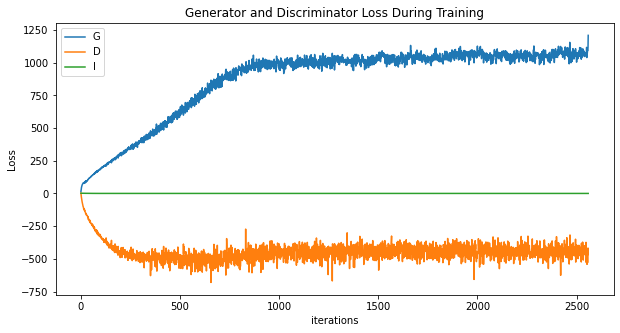

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(I_losses,label="I")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

In [22]:
# #%%capture
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side.

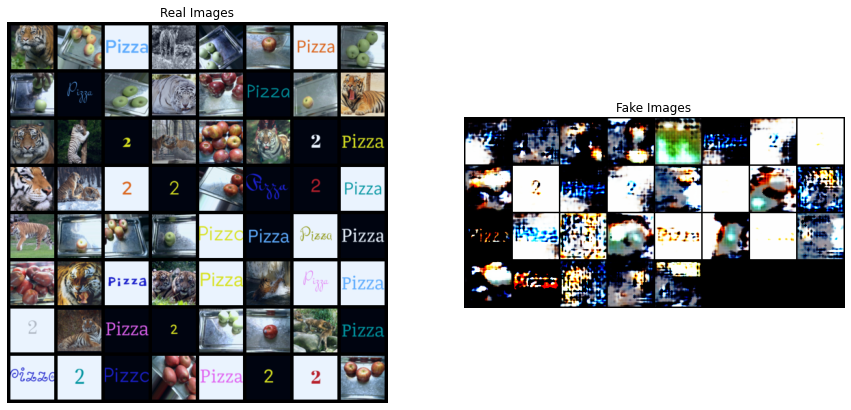

In [21]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()